## Objective

The report explores two datasets that are relevant to the project - [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/) and [VinBig](https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection).

This report contains the following:

1. We first analyse the data, see few images from both the datasets.
2. We then get a feature vector for each images.
3. Apply PCA to the feature vector and observe few of the characteristics.


## Importing the required libraries



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.image as mpimg
import random
from scipy.spatial import distance

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
! kaggle datasets download -d 'mimsadiislam/chexpert'

In [ ]:
!unzip -q /content/chexpert.zip

In [ ]:
! kaggle datasets download -d 'corochann/vinbigdata-chest-xray-original-png'

In [ ]:
! unzip -q /content/vinbigdata-chest-xray-original-png.zip

In [ ]:
cheXpert_path = np.load('cheXpert_path.npy')
vinBig_path = np.load('vinbig_path.npy')

In [ ]:
def display_random_sample_images(image_paths, title):
    # Randomly pick 9 images from the list
    random_images = list(np.random.permutation(image_paths)[:9])

    # Create a 3x3 grid for displaying the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(3):
        for j in range(3):
            if not random_images:
                break
            img_path = random_images.pop()
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')  # Turn off axes
            axes[i, j].set_title('Image {}'.format(9 - len(random_images)))

    # Remove any empty subplots
    for i in range(len(random_images)):
        axes[i // 3, i % 3].remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

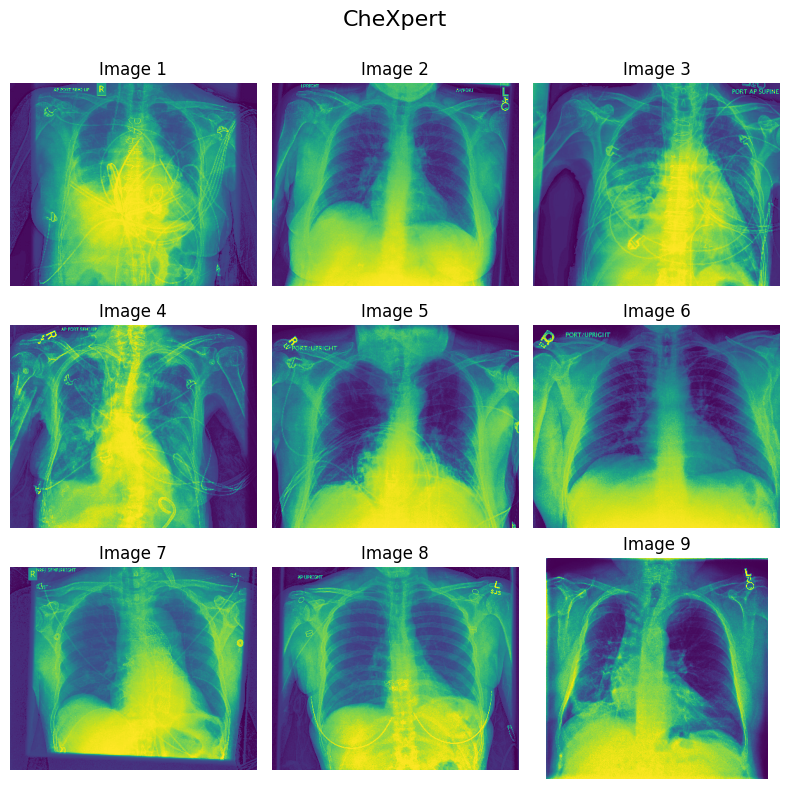

In [ ]:
display_random_sample_images(cheXpert_path, "CheXpert")

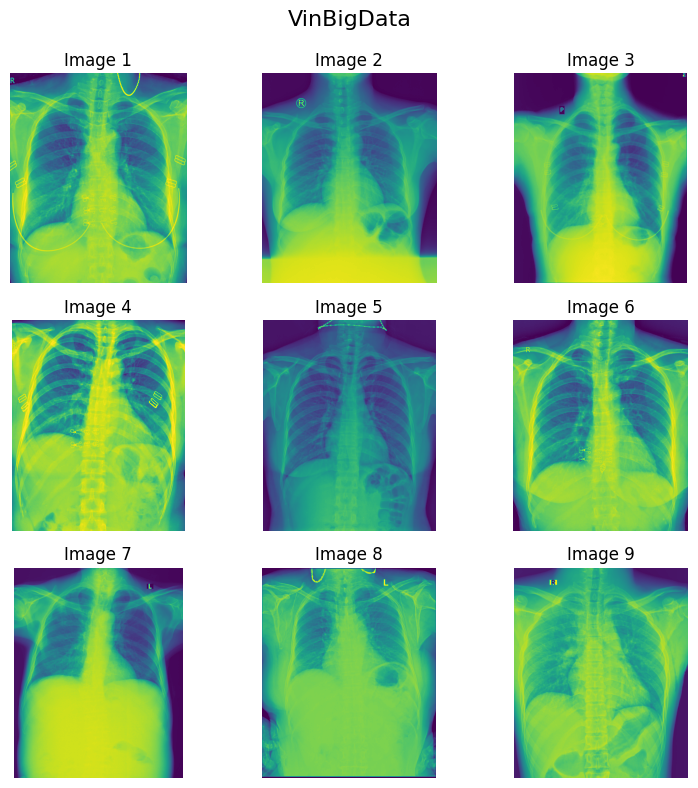

In [ ]:
display_random_sample_images(vinBig_path, "VinBigData")

An observation from both the images is that the VinBigData is much more cleaner.

# Loading the necessary the feature vector

We randomly select 1000 images from both the dataset and perform PCA on it.

In [4]:
def min_max_scaling(data):
    """
    Perform Min-Max scaling on a dataset.

    Parameters:
    - data: numpy array of shape (n_samples, n_dimensions)

    Returns:
    - scaled_data: numpy array of the same shape, scaled to the range [0, 1]
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero
    max_vals[max_vals == min_vals] = 1.0

    scaled_data = (data - min_vals) / (max_vals - min_vals)

    return scaled_data

In [6]:
cheXpert = min_max_scaling(np.load('cheXpert.npy'))
vinbig = min_max_scaling(np.load('vinbig.npy'))

In [7]:
cheXpert_seg = min_max_scaling(np.load('seg_cheXpert_latent.npy'))
vinbig_seg = min_max_scaling(np.load('seg_vinbig_latent.npy'))

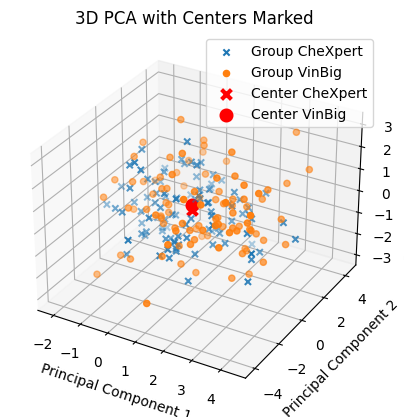

In [8]:
# Perform PCA for 3D
pca = PCA(n_components=3)
data_x_pca = pca.fit_transform(cheXpert + vinbig)
data_o_pca = pca.transform(vinbig)
data_x_pca = pca.transform(cheXpert)

# Calculate the centers of group X and group O
center_x = np.mean(data_x_pca, axis=0)
center_o = np.mean(data_o_pca, axis=0)

# Plot the results in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_x_pca[:100, 0], data_x_pca[:100, 1], data_x_pca[:100, 2], marker='x', label='Group CheXpert')
ax.scatter(data_o_pca[:100, 0], data_o_pca[:100, 1], data_o_pca[:100, 2], marker='o', label='Group VinBig')
ax.scatter(center_x[0], center_x[1], center_x[2], color='red', s=50, marker='x', label='Center CheXpert', linewidths=3)
ax.scatter(center_o[0], center_o[1], center_o[2], color='red', s=50, marker='o', label='Center VinBig', linewidths=3)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.title('3D PCA with Centers Marked')
plt.show()

## Variance

In [ ]:
np.var(data_x_pca, axis=0)

array([2.4099495, 2.2162433, 1.4875228], dtype=float32)

## Distace b/w centers

In [ ]:
np.linalg.norm(center_o - center_x)

0.23703434

### After Segmentation


In [ ]:
np.var(data_x_pca, axis=0)

array([15.236419 ,  1.856449 ,  1.6534153], dtype=float32)

In [ ]:
np.linalg.norm(center_o - center_x)

1.4190335

## TSNE


In [9]:
def visualize_tsne_with_centers(data1, data2, labels1, labels2):
    # Combine the two datasets
    combined_data = np.concatenate([data1, data2])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)

    # Separate the datasets
    reduced_data1 = reduced_data[:len(data1)]
    reduced_data2 = reduced_data[len(data1):]

    # Calculate and plot the centers
    center1 = np.mean(reduced_data1, axis=0)
    center2 = np.mean(reduced_data2, axis=0)

    print('variance is ' + str(np.var(reduced_data, axis=0)))

    plt.figure(figsize=(10, 6))

    # Scatter plot with labels
    plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], label=labels1, alpha=0.7, cmap='viridis')
    plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], label=labels2, alpha=0.7, cmap='viridis')

    # Plot centers
    plt.scatter(center1[0], center1[1], marker='x', s=200, color='red', label=labels1 + ' Center')
    plt.scatter(center2[0], center2[1], marker='x', s=200, color='blue', label=labels2 + ' Center')

    # Calculate and print the distance between the centers
    dist = distance.euclidean(center1, center2)
    print(f"Distance between centers: {dist}")

    plt.set_xlabel('Principal Component 1')
    plt.set_ylabel('Principal Component 2')
    plt.set_zlabel('Principal Component 3')

    # Display plot
    plt.title('t-SNE Visualization with Centers')
    plt.legend()
    plt.show()

In [10]:
visualize_tsne_with_centers(cheXpert, vinbig, "CheXpert", "VinBig")

KeyboardInterrupt: 

variance is [956.57184 370.75552]
Distance between centers: 34.331146240234375


<ipython-input-21-3acca5575bb7>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], label=labels1, alpha=0.7, cmap='viridis')
<ipython-input-21-3acca5575bb7>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], label=labels2, alpha=0.7, cmap='viridis')


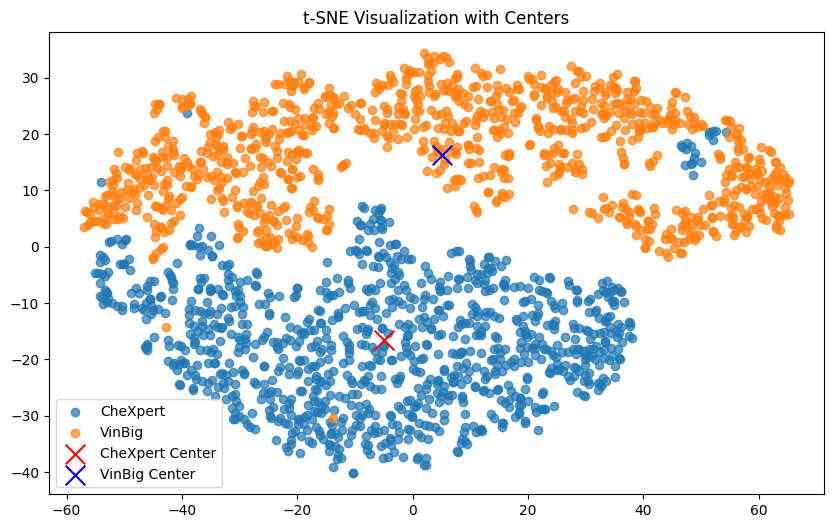

In [ ]:
visualize_tsne_with_centers(cheXpert_seg, vinbig_seg, "CheXpert", "VinBig")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from scipy.spatial import distance

def visualize_tsne_with_centers_3d(data1, data2, labels1, labels2, title):
    # Combine the two datasets
    combined_data = np.concatenate([data1, data2])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=3, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)

    # Separate the datasets
    reduced_data1 = reduced_data[:len(data1)]
    reduced_data2 = reduced_data[len(data1):]

    # Calculate and plot the centers
    center1 = np.mean(reduced_data1, axis=0)
    center2 = np.mean(reduced_data2, axis=0)

    print('variance is ' + str(np.var(reduced_data, axis=0)))

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with labels
    ax.scatter(reduced_data1[:, 0], reduced_data1[:, 1], reduced_data1[:, 2], label=labels1, alpha=0.7, cmap='viridis')
    ax.scatter(reduced_data2[:, 0], reduced_data2[:, 1], reduced_data2[:, 2], label=labels2, alpha=0.7, cmap='viridis')

    # Plot centers
    ax.scatter(center1[0], center1[1], center1[2], marker='x', s=100, color='red', label=labels1 + ' Center', alpha = 1)
    ax.scatter(center2[0], center2[1], center2[2], marker='x', s=100, color='blue', label=labels2 + ' Center', alpha = 1)

    # Calculate and print the distance between the centers
    dist = distance.euclidean(center1, center2)
    print(f"Distance between centers: {dist}")

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    # Display plot
    ax.set_title(title)
    ax.legend()
    plt.show()


variance is [ 51.054867  67.30287  271.46127 ]
Distance between centers: 29.374046325683594


<ipython-input-11-e520b60e4694>:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_data1[:, 0], reduced_data1[:, 1], reduced_data1[:, 2], label=labels1, alpha=0.7, cmap='viridis')
<ipython-input-11-e520b60e4694>:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_data2[:, 0], reduced_data2[:, 1], reduced_data2[:, 2], label=labels2, alpha=0.7, cmap='viridis')


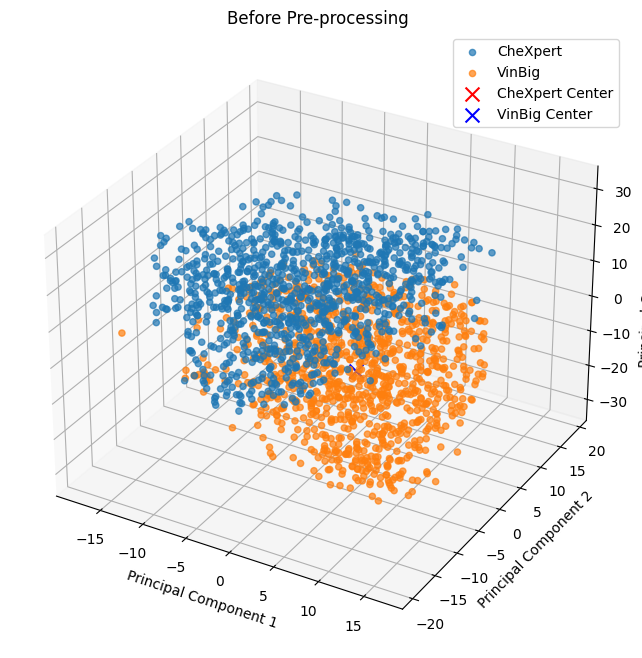

In [12]:
visualize_tsne_with_centers_3d(cheXpert, vinbig, "CheXpert", "VinBig", "Before Pre-processing")

variance is [92.19763  28.255934 16.10575 ]
Distance between centers: 10.328544616699219


<ipython-input-11-e520b60e4694>:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_data1[:, 0], reduced_data1[:, 1], reduced_data1[:, 2], label=labels1, alpha=0.7, cmap='viridis')
<ipython-input-11-e520b60e4694>:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_data2[:, 0], reduced_data2[:, 1], reduced_data2[:, 2], label=labels2, alpha=0.7, cmap='viridis')


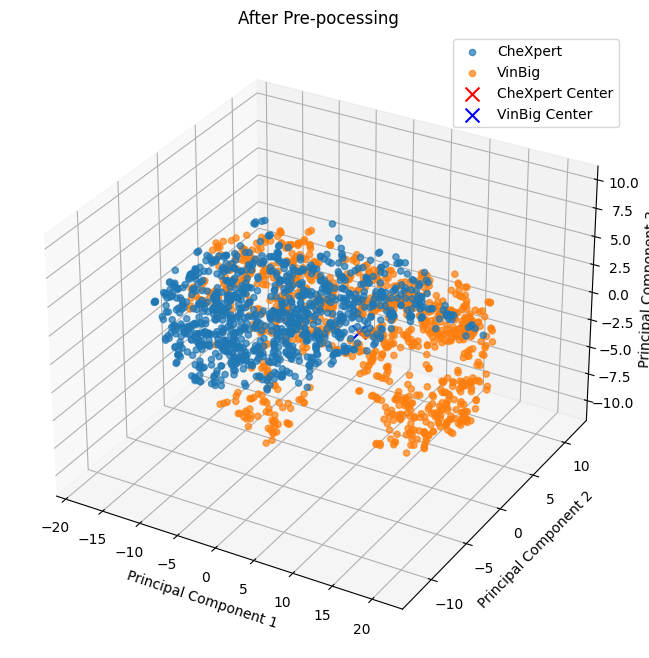

In [13]:
visualize_tsne_with_centers_3d(cheXpert_seg, vinbig_seg, "CheXpert", "VinBig", "After Pre-pocessing")

## How does this relate to the research?

The objective of the research is to build a generic model for chest x-rays. This means that the model should be able to handle data from multiple dataset and this is an example of how much deviation is there between two datasets of chest x-rays CheXpert and VinBigData. CheXpert was collected from predominantly US and Israel population while VinBigData was collected from a chinese demographic.

Further we try to apply few pre-processing techniques to reduce the variance of PCA and the distance between the centers so the models can treat the x-rays with minimal bias. These bias can include the x-ray machines, the text thats on the x-rays and much more.